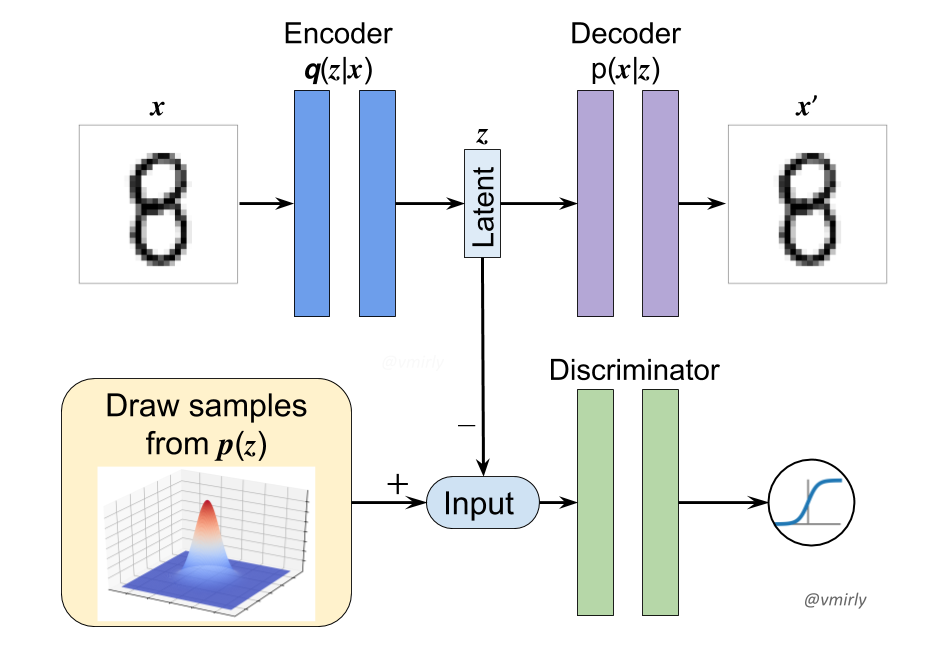

In [1]:
from IPython.display import Image
Image("figs/adversarial-autoencoder.png")

Ref: **Adversarial Autoencoders**, by A Makhzani, J Shlens, N Jaitly, I Goodfellow, and B Frey [Link to Publication:](https://arxiv.org/abs/1511.05644)

**Note:** This implementaiton uses a deterministic encoder.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [2]:
## Settings:

# CUDA Device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
num_epochs = 20
batch_size = 128
learning_rate = 0.001
lambda_gp = 10.0
lambda_rec = 1.0
lambda_src = 1.0
n_critics = 2

# Model Parameters
num_features = 784
num_hidden = 100
num_latent = 20
num_disc_logits = 2


Device: cuda:0


In [3]:
## MNIST Data Loader

train_dataset = datasets.MNIST(root='./mnist/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_dataset = datasets.MNIST(root='./mnist/', 
                              train=False, 
                              transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
images, labels = next(iter(train_loader))
print('Images dimension:', images.shape)
print('Labels dimension:', labels.shape)


Images dimension: torch.Size([128, 1, 28, 28])
Labels dimension: torch.Size([128])


# Class for Adversarial Autoencoder

In [4]:
###### MODEL: Generator ######

class Autoencoder(nn.Module):
    """Serves as the generator network (G)"""
    def __init__(self, num_features, num_hidden, num_latent):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(num_features, num_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden, num_latent))
        self.decoder = nn.Sequential(
            nn.Linear(num_latent, num_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden, num_features))

    def forward(self, x, from_latent=False, return_mode='both'):
        """return_mode: [
            'latent': will return the latent vector (z)
            'logits': will return the final reconstruction logits
            'output': will return the final output after applying sigmoid
            ]
        """
        if not from_latent:
            z = self.encoder(x)
            if return_mode == 'latent':
                return z
        else:
            z = x
        
        if return_mode == 'logits':
            return z, self.decoder(z)
        elif return_mode == 'output':
            return torch.sigmoid(self.decoder(z))

###### MODEL: Discriminator ######

class Discriminator(nn.Module):
    """Discriminator network (D)"""
    def __init__(self, num_ae_latent=20, num_hidden=64, num_logits=5):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(num_ae_latent, num_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden, num_logits))
        
    def forward(self, x):
        return self.main(x)

# Solver class

In [5]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2"""
    weight = torch.ones(y.size()).to(device)
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    return torch.mean((dydx_l2norm-1)**2)


class Solver():
    def __init__(self, num_features, num_hidden, num_latent, num_disc_logits, n_critics,
                 lambda_src, lambda_gp, learning_rate, device):
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_latent = num_latent
        self.num_disc_logits = num_disc_logits
        self.lambda_src = lambda_src
        self.lambda_gp = lambda_gp
        self.n_critics = n_critics
        self.learning_rate = learning_rate
        self.device = device
        
        self.build_model()
        
    def build_model(self):
        self.G = Autoencoder(self.num_features, self.num_hidden, self.num_latent)
        self.D = Discriminator(self.num_latent, self.num_hidden, self.num_disc_logits)
        
        self.G = self.G.to(self.device)
        self.D = self.D.to(self.device)

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=self.learning_rate)
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=self.learning_rate)

    def reset_grads(self):
        """A helper function to reset gradient buffers"""
        self.g_optimizer.zero_grad()
        self.d_optimizer.zero_grad()

    def train(self, train_loader, num_epochs=10):
        #======================================================= #
        #                       Training                         #
        #======================================================= #

        for epoch in range(num_epochs):
            for batch_idx, (images, labels) in enumerate(train_loader):

                images = images.to(self.device).view(-1, 28*28)

                # ======================================================= #
                #                 1. Train the discriminator              #
                # ======================================================= #
                z_real = torch.randn(images.size(0), num_latent).to(self.device)
                out_real = self.D(z_real)
                d_loss_real = -torch.mean(out_real)

                z_fake = self.G(images, return_mode='latent')
                out_fake = self.D(z_fake)
                d_loss_fake = torch.mean(out_fake)

                ## >> gradient-penalty
                alpha = torch.rand(z_real.size(0), 1).to(self.device)
                z_fake_hat = (alpha * z_real.detach() + (1 - alpha) * z_fake.detach()).requires_grad_(True)
                out_fake_hat = self.D(z_fake_hat)
                d_loss_gp = gradient_penalty(out_fake_hat, z_fake_hat)

                d_loss = (lambda_src*(d_loss_real + d_loss_fake) + 
                          lambda_gp*d_loss_gp)

                self.reset_grads()
                d_loss.backward()
                self.d_optimizer.step()

                # ======================================================= #
                #                2. Train the generator (AE)              #
                # ======================================================= #
                if batch_idx % self.n_critics == 0:
                    z_fake, x_rec = self.G(images, return_mode='logits')
                    out_fake = self.D(z_fake)
                    g_loss_fake = -torch.mean(out_fake)

                    g_loss_rec = F.binary_cross_entropy_with_logits(
                                x_rec, images, reduction='sum') / images.size(0)

                    g_loss = lambda_src*g_loss_fake + lambda_rec*g_loss_rec

                    self.reset_grads()
                    g_loss.backward()
                    self.g_optimizer.step()

                if not batch_idx % 200:
                    print ('Epoch: {:03d}/{:03d}  Iter. {:03d}/{:03d} |'.format(
                           epoch+1, num_epochs, batch_idx, len(train_dataset)//batch_size), end=' ')
                    print('G-loss: {:.3f} {:.3f} | D-loss: {:.3f} {:.3f} {:.3f}'.format(
                           g_loss_fake, g_loss_rec, d_loss_real, d_loss_fake, d_loss_gp))



# Training

In [9]:

torch.manual_seed(random_seed)


aae_solver = Solver(num_features, num_hidden, num_latent, num_disc_logits, n_critics,
                    lambda_src, lambda_gp, learning_rate, device)

aae_solver.train(train_loader, num_epochs)

Epoch: 001/020  Iter. 000/468 | G-loss: -0.031 545.914 | D-loss: -0.153 0.031 0.440
Epoch: 001/020  Iter. 200/468 | G-loss: 7.556 189.749 | D-loss: -0.055 -7.556 0.101
Epoch: 001/020  Iter. 400/468 | G-loss: 4.612 155.301 | D-loss: 0.148 -4.601 0.036
Epoch: 002/020  Iter. 000/468 | G-loss: 5.018 135.214 | D-loss: 0.467 -5.010 0.039
Epoch: 002/020  Iter. 200/468 | G-loss: 4.593 134.182 | D-loss: 0.758 -4.594 0.030
Epoch: 002/020  Iter. 400/468 | G-loss: 4.596 120.326 | D-loss: 1.042 -4.596 0.030
Epoch: 003/020  Iter. 000/468 | G-loss: 4.790 111.166 | D-loss: 1.088 -4.784 0.026
Epoch: 003/020  Iter. 200/468 | G-loss: 4.718 109.686 | D-loss: 1.330 -4.719 0.026
Epoch: 003/020  Iter. 400/468 | G-loss: 4.731 106.884 | D-loss: 1.548 -4.727 0.020
Epoch: 004/020  Iter. 000/468 | G-loss: 4.753 103.562 | D-loss: 1.628 -4.748 0.021
Epoch: 004/020  Iter. 200/468 | G-loss: 5.078 96.441 | D-loss: 1.795 -5.081 0.022
Epoch: 004/020  Iter. 400/468 | G-loss: 4.798 95.308 | D-loss: 1.883 -4.790 0.016
Epoc

# Evaluation

## Part-1: Evaluation based on input

torch.Size([128, 1, 28, 28])
torch.Size([20, 1, 28, 28])


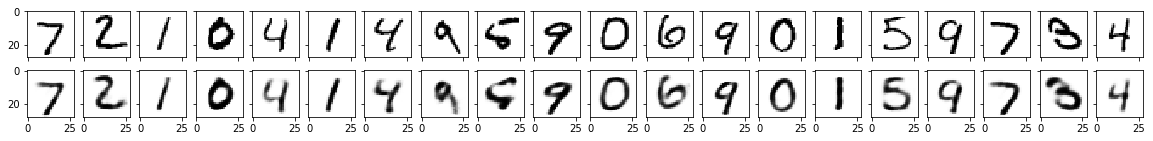

In [10]:

%matplotlib inline
import matplotlib.pyplot as plt

G = aae_solver.G

n_images = 20
image_width, image_height = 28, 28

images, labels = next(iter(test_loader))
print(images.shape)
fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2))
input_images = images[:n_images]
print(input_images.shape)
outputs = G(input_images.to(device).view(-1, image_width*image_height), return_mode='output')
output_images = outputs.cpu()

for i in range(n_images):
    for ax, img in zip(axes, [input_images, output_images]):
        ax[i].imshow(img[i].detach().reshape((image_width, image_width)), cmap='binary')

## Part-2: Evalaution based on latent space sampled from $p(z)$

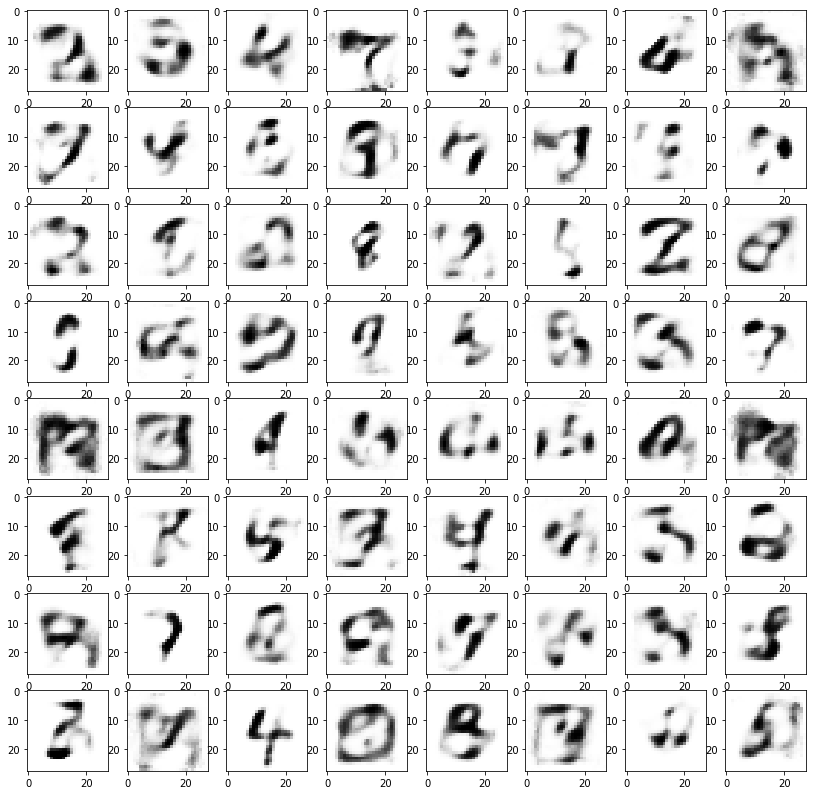

In [11]:
n_images = 64
latent = torch.randn(n_images, num_latent).to(device)

outputs = G(latent, from_latent=True, return_mode='output')

fig = plt.figure(figsize=(14, 14))
for i in range(n_images):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(outputs[i].detach().reshape((image_width, image_width)), cmap='binary')